In [1]:
import os
import time
import glob
import random
import re
import cv2
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
num_classes = 1

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features
        for i,param in enumerate(self.encoder.parameters()):
            param.requires_grad = i >= 16
        self.decoder1x1 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.convT2d1 = nn.ConvTranspose2d(in_channels=1, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.convT2d2 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=4, padding=0)
        self.convT2d3 = nn.ConvTranspose2d(in_channels=512, out_channels=1, kernel_size=4, stride=4, padding=0)
    
    def forward(self, x):

        skipConnections = {}
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i in [23, 15]:
                skipConnections[i] = x
                
        x = self.decoder1x1(x)
        x = self.convT2d1(x)
        x = torch.cat((x,skipConnections[23]), 1)
        x = self.convT2d2(x)
        x = torch.cat((x, skipConnections[15]), 1)
        x = self.convT2d3(x)
        x = nn.Sigmoid()(x)
        x = x.view(x.size()[0], -1, num_classes)
        
        return x

net = Net()
net.cuda()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(

In [3]:
background_color = np.array([255, 255, 255])
class UltrasoundDataset(data.Dataset):
    def __init__(self, mask_list, input_preprocessor):
        mask_notall_black = [x for x in mask_list if not self.isAllBlack(x)]
        self.y = mask_notall_black
        self.x = [grp.group(1)+grp.group(2) for grp in [re.match(r'(.*)_mask(\.tif)', x) for x in mask_notall_black]]
        self.input_preprocessor = input_preprocessor
        
    def isAllBlack(self, x):
        return np.all(self.imread(x)[:,:] == [0,0,0])
        
    def imread(self, file_name):
        return cv2.imread(file_name)[2: 418, 2:578]
    
    def inputimage(self, file_name):
        return self.input_preprocessor(self.imread(file_name))
    
    def labelread(self, file_name):
        img = self.imread(file_name)
        
        gt_bg = np.all(img == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        
        class1 = np.zeros(gt_bg.shape, dtype=np.float32)
        class1[gt_bg] = 1.
        return class1.reshape(-1, num_classes)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.inputimage(self.x[idx]), self.labelread(self.y[idx])

input_processor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


filelist = glob.glob('./data/train_orig/*_mask.tif')
val_percent = 20
val_items = val_percent*len(filelist)//100

random.shuffle(filelist)

batch_size = 10

validation_list = filelist[0: val_items]
val_dataset = UltrasoundDataset(validation_list, input_processor)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

train_list = filelist[val_items:]
train_dataset = UltrasoundDataset(train_list, input_processor)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)


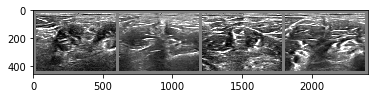

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4,padding=20))


In [5]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def fscore_loss(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return (1+4)*(presci * rec)/(4*presci + rec)

In [6]:
def train(data_loader, net, criterion, optimizer, epoch):
    net.train(True)
    train_loss = 0.
    for i, (inputs, labels) in enumerate(data_loader, 0):
        print("Training epoch %d: batch # %d" % (epoch, i), end='\r')
        # map to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss / len(data_loader)

def validate(data_loader, net, criterion, measures, epoch):
    net.train(False)
    val_loss = 0.
    measurements = {k:0. for k in measures.keys()}
    for i, (inputs, labels) in enumerate(data_loader, 0):
        print("Validating epoch %d: batch # %d" % (epoch, i), end='\r')
        # map to gpu
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        for (k,m) in measures.items():
            measurements[k] += m(outputs, labels).item()
        
        val_loss += loss.item()
    
    for k in measures.keys():
        measurements[k] = measurements[k] / len(data_loader)
    return val_loss / len(data_loader), measurements

In [7]:
criterion = dice_coef_loss
optimizer = optim.Adam(net.parameters(), lr=1e-5)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
measures = {'iou':iou, 'fp': falsepos, 'fn': falseneg, 'precision': precision, 'recall': recall, 'fscore': fscore }

for epoch in range(10):  # loop over the dataset multiple times
    train_loss = train(train_loader, net, criterion, optimizer, epoch)
    val_loss, measurements = validate(val_loader, net, criterion, measures, epoch)
    lrscheduler.step(val_loss)
    
    print("epoch {}: train-loss={:.5f}, val-loss={:.5f}, new_lr={:.5f}".format(epoch, train_loss, val_loss, optimizer.param_groups[0]['lr']))
    for k,v in measurements.items():
        print(" {}:{:.5f}".format(k,v), end=',')
    print()

print('Finished Training')

epoch 0: train-loss=-0.16329, val-loss=-0.38402, new_lr=0.00001
iou:0.24048, fp:43595.30945, fn:41467.20230, precision:0.38083, recall:0.39902, fscore:0.39096, 
epoch 1: train-loss=-0.50389, val-loss=-0.56295, new_lr=0.00001
iou:0.39655, fp:35343.88147, fn:18088.18835, precision:0.49882, recall:0.66069, fscore:0.61564, 
epoch 2: train-loss=-0.59565, val-loss=-0.56611, new_lr=0.00001
iou:0.39769, fp:16862.50716, fn:65717.99618, precision:0.76141, recall:0.45376, fscore:0.49257, 
epoch 3: train-loss=-0.63942, val-loss=-0.63448, new_lr=0.00001
iou:0.47029, fp:30959.60319, fn:13498.31173, precision:0.56178, recall:0.74650, fscore:0.69443, 
epoch 4: train-loss=-0.66755, val-loss=-0.65009, new_lr=0.00001
iou:0.48721, fp:30094.74662, fn:12375.43746, precision:0.57412, recall:0.76665, fscore:0.71257, 


Traceback (most recent call last):
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/anand/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/anand/anaconda3/envs/torch/lib/python3

KeyboardInterrupt: 

In [ ]:
model_name = './ultrasound_%s.pth' % time.strftime('%m%d%H%M')
torch.save(net.state_dict(), model_name)

In [ ]:
IMAGE_HT = 416
IMAGE_WD = 576

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
output = net(images)

for idx in range(10):
    x, y, label = images[idx], output[idx], labels[idx]
    
    pred = y.reshape(IMAGE_HT, IMAGE_WD)
    pred = pred.cpu()
    pred = pred.detach().numpy()
    y=np.zeros(pred.shape, dtype=np.uint8)
    y[pred > 0.1] = 255
    
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(y, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(label.reshape(IMAGE_HT, IMAGE_WD), cmap='gray')
